# Potato Disease Classification

### Import all the Dependencies

In [70]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [71]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

In [72]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [73]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [74]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualizing some of the images from our dataset

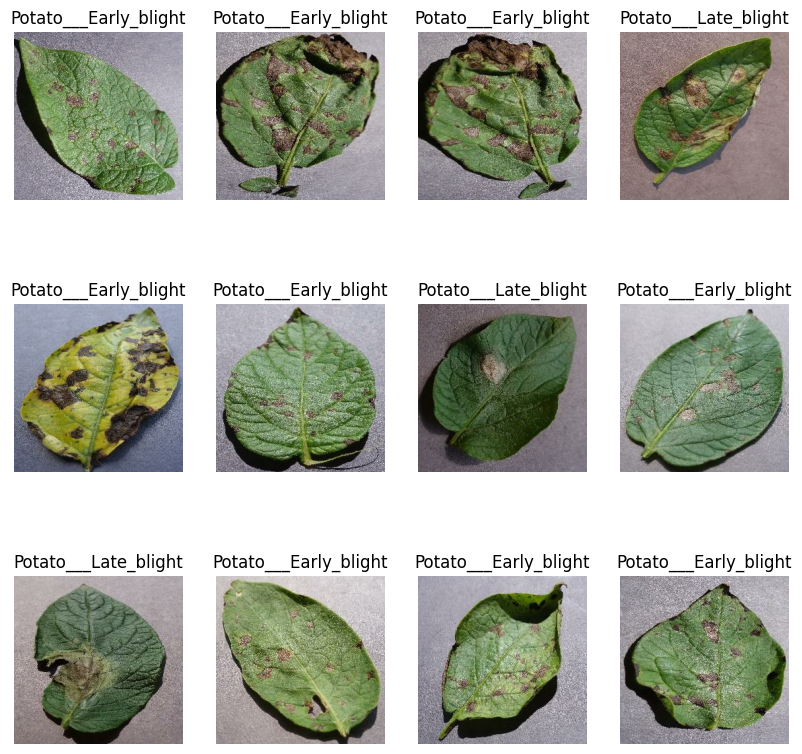

In [75]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Splitting The Dataset

In [76]:
len(dataset)

68

In [77]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [78]:
train_ds = dataset.take(54)
len(train_ds)

54

In [79]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [80]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [81]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [82]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [83]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [84]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [85]:
len(train_ds)

54

In [86]:
len(val_ds)

6

In [87]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [88]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [89]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1.0/255),
])

### Data Augmentation

In [90]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [91]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Building

In [ ]:
from keras import layers, Sequential

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3 

model = models.Sequential([
    resize_and_rescale,  
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),  
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [93]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

### Compiling the Model


In [94]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 67s 1s/step - loss: 0.9369 - accuracy: 0.4740 - val_loss: 0.9169 - val_accuracy: 0.6094
Epoch 2/50
54/54 [==============================] - 65s 1s/step - loss: 0.8591 - accuracy: 0.5666 - val_loss: 0.7855 - val_accuracy: 0.6667
Epoch 3/50
54/54 [==============================] - 82s 2s/step - loss: 0.6284 - accuracy: 0.7483 - val_loss: 0.6518 - val_accuracy: 0.7031
Epoch 4/50
54/54 [==============================] - 50s 932ms/step - loss: 0.4563 - accuracy: 0.8090 - val_loss: 0.3968 - val_accuracy: 0.8125
Epoch 5/50
54/54 [==============================] - 59s 1s/step - loss: 0.3522 - accuracy: 0.8559 - val_loss: 0.3112 - val_accuracy: 0.8594
Epoch 6/50
54/54 [==============================] - 57s 1s/step - loss: 0.2711 - accuracy: 0.8929 - val_loss: 0.3549 - val_accuracy: 0.8646
Epoch 7/50
54/54 [==============================] - 56s 1s/step - loss: 0.2317 - accuracy: 0.9086 - val_loss: 0.2931 - val_accuracy: 0.8854
Epoch 8/50
54/54 

In [97]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 217ms/step - loss: 0.0958 - accuracy: 0.9727


In [98]:
scores

[0.09582105278968811, 0.97265625]

### Plotting the Accuracy and Loss Curves

In [99]:
history

In [100]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [101]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [102]:
type(history.history['loss'])

list

In [103]:
len(history.history['loss'])

50

In [ ]:
history.history['loss'][:5] 

[0.9369089603424072,
 0.859131395816803,
 0.6283737421035767,
 0.4562758803367615,
 0.35221201181411743]

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

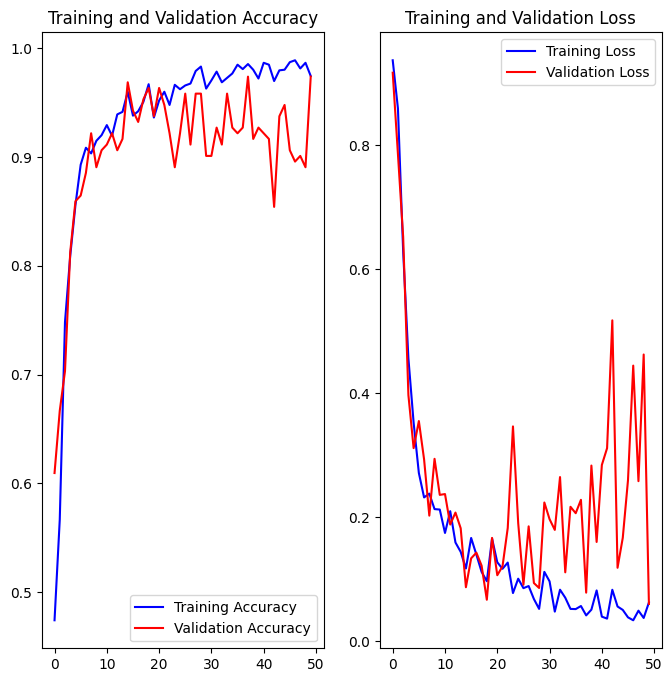

In [106]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy', color = 'blue')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy', color = 'red')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss', color = 'blue')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss', color ='red')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 131ms/step
[9.99997854e-01 2.16192393e-06 1.07124325e-13]
predicted label: Potato___Early_blight


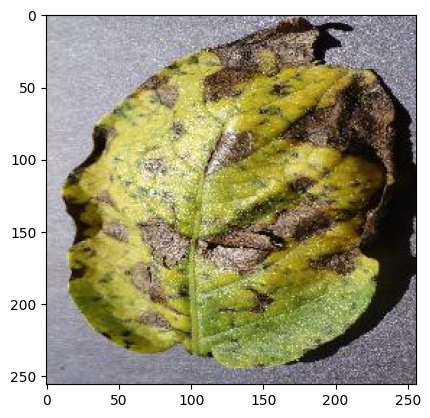

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [108]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Inference on few sample images**

1/1 [==============================] - 0s 25ms/step


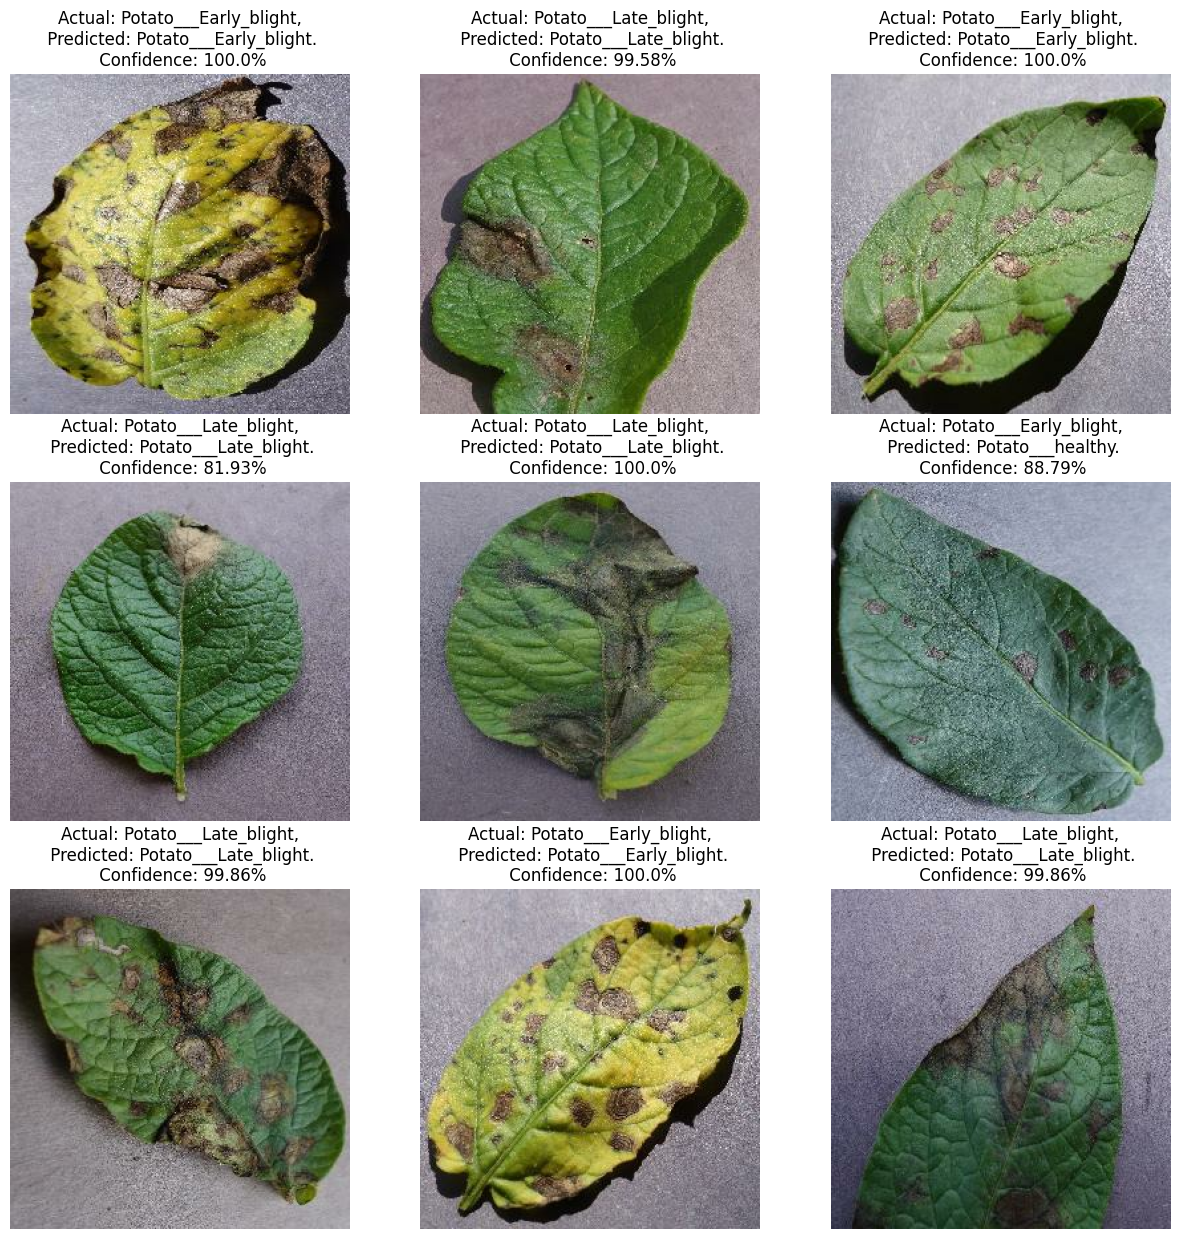

In [109]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model

In [110]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
tf.keras.models.save_model(model, f"../saved_models/{model_version}")


INFO:tensorflow:Assets written to: ../saved_models/3\assets


INFO:tensorflow:Assets written to: ../saved_models/3\assets
